## Data Analysis

In [145]:
import os
import dotenv

dotenv.load_dotenv()
DB_HOST = os.getenv('GP_DB_HOST')
DB_PORT = os.getenv('GP_DB_PORT')
DB_USER = os.getenv('GP_DB_USER')
DB_PASS = os.getenv('GP_DB_PASS')
DB_NAME = os.getenv('GP_DB_NAME')

# DB_HOST = "groupseven.c7uho3baxiu8.us-west-2.rds.amazonaws.com"
# DB_NAME = "groupseven"
# DB_USER = "seven"
# DB_PASS = "BAIT580SQL"
# DB_PORT = "5432"

conString = {'host':DB_HOST,
             'user':DB_USER,
             'dbname':DB_NAME,
             'password':DB_PASS,
             'port':DB_PORT}

# Data manipulation
import pandas as pd
import missingno as msno

import numpy as np
import psycopg2

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import altair as alt
import matplotlib as plt
alt.data_transformers.disable_max_rows()  # disable error for big datasets

DataTransformerRegistry.enable('default')

Establishing Connection

In [146]:
conn = psycopg2.connect(**conString)
cur = conn.cursor()

In [147]:
# cur.execute("""SELECT * FROM edx.wrld_bnk_indc""")
# res = cur.fetchall()

# df = pd.DataFrame(res)

In [148]:
# df.columns=['country_name','country_code','year','edu_pcnt_scnd_bud','sch_enr_sec','edu_pcnt_prim_bud','edu_pcnt_gdp_pstudcapita_scnd','edu_pcnt_gdp_pstudcapita_prim',
#              'edu_pcnt_ter_bud','edu_pcnt_bud','sch_enr_pri','edu_pcnt_gdp_pstud_capita_ter','edu_pcnt_gdp']

# df

In [151]:
cur.execute('''SELECT hc.country_code, hc.country_name, hc.year, val_qual_edsys, val_qual_ed, val_qual_mathsci_edsys, sch_enr_tert,
            sch_enr_sec, sch_enr_pri, perc_grad_stem, perc_grad_nonstem, edu_pcnt_gdp, edu_pcnt_bud,edu_pcnt_ter_bud,
            edu_pcnt_gdp_pstudcapita_ter,edu_pcnt_scnd_bud,edu_pcnt_gdp_pstudcapita_scnd,edu_pcnt_prim_bud,
            edu_pcnt_gdp_pstudcapita_prim,hdi,gdp_growth,gdp_us
FROM edx.human_capital as hc INNER JOIN edx.education_indicators as ei ON hc.country_code = ei.country_code and hc.year = ei.year
WHERE hc.year>=2000''')
edu_indicators = pd.DataFrame(cur.fetchall())

In [152]:
#edu_indicators.columns=['country_name','country_code','year','val_qual_edsys','val_qual_ed','val_qual_mathsci_edsys','perc_grad_stem','perc_grad_nonstem','sch_enr_tert','sch_enr_sec','sch_enr_pri']
edu_indicators.columns = ['country_name', 'country_code' ,'year', 'val_qual_edsys', 'val_qual_ed', 'val_qual_mathsci_edsys', 'sch_enr_tert','sch_enr_sec', 
                          'sch_enr_pri', 'perc_grad_stem', 'perc_grad_nonstem','edu_pcnt_gdp', 'edu_pcnt_bud',
                          'edu_pcnt_ter_bud','edu_pcnt_gdp_pstudcapita_ter','edu_pcnt_scnd_bud','edu_pcnt_gdp_pstudcapita_scnd','edu_pcnt_prim_bud','edu_pcnt_gdp_pstudcapita_prim',
                          'hdi','gdp_growth','gdp_us']
selected_countries = ['USA', 'UK', 'CAN', 'EGY', 'BRA', 'ARG', 'FRA', 'GER', 'CHN', 'IND', 'ITA', 'JPN', 'KOR', 'FIN', 'AUS', 'SAU','ZAF','NGA']

edu_indicators_selected = edu_indicators[edu_indicators['country_code'].isin(selected_countries)]
edu_indicators_selected.head()

,country_name,country_code,year,val_qual_edsys,val_qual_ed,val_qual_mathsci_edsys,sch_enr_tert,sch_enr_sec,sch_enr_pri,perc_grad_stem,perc_grad_nonstem,edu_pcnt_gdp,edu_pcnt_bud,edu_pcnt_ter_bud,edu_pcnt_gdp_pstudcapita_ter,edu_pcnt_scnd_bud,edu_pcnt_gdp_pstudcapita_scnd,edu_pcnt_prim_bud,edu_pcnt_gdp_pstudcapita_prim,hdi,gdp_growth,gdp_us


<AxesSubplot:>

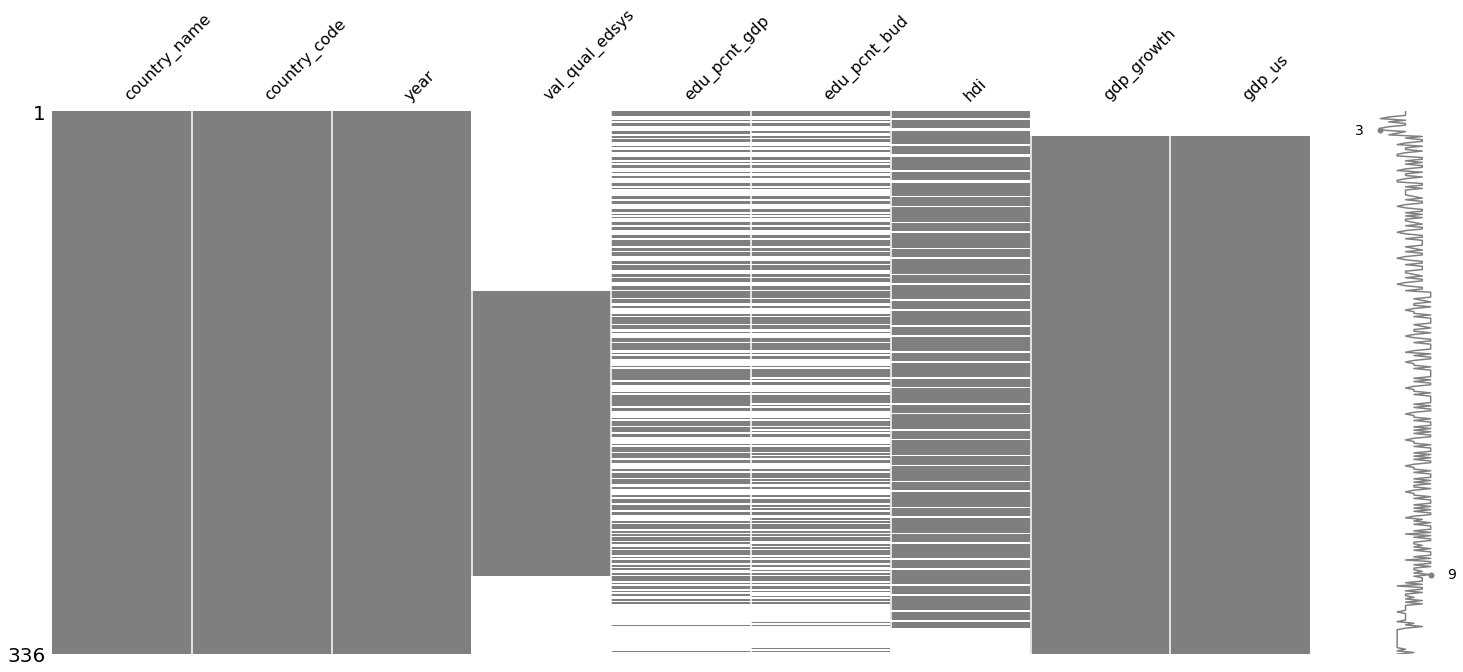

In [132]:
import missingno as msno

msno.matrix(edu_indicators_selected,color='0.5')

GridSpec(6, 6)

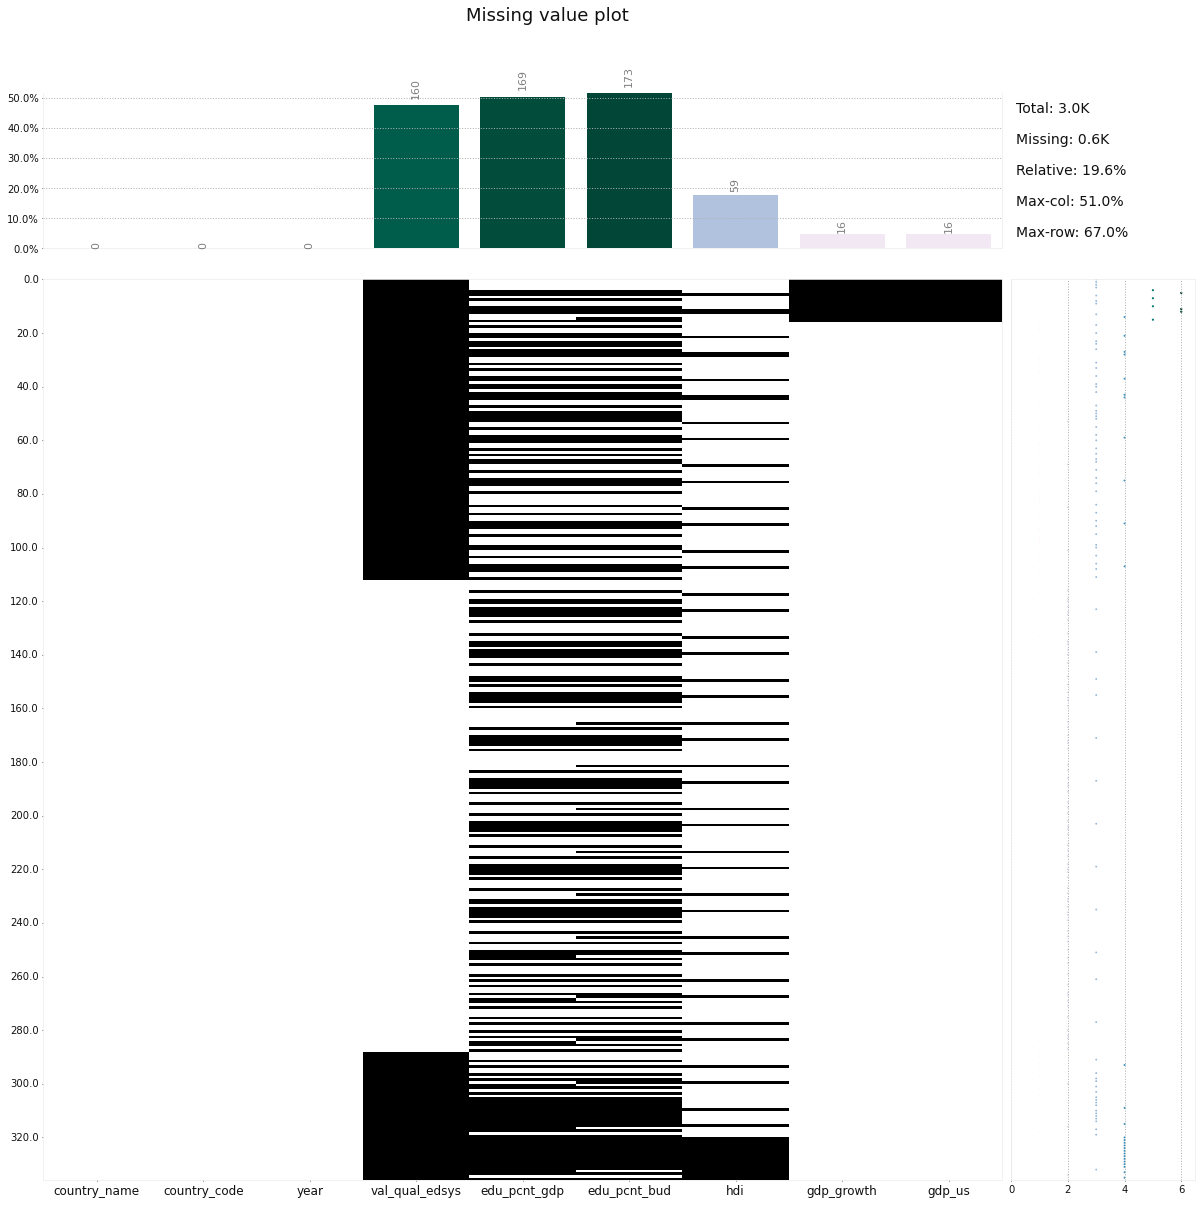

In [138]:
import klib
klib.missingval_plot(edu_indicators_selected)

Text(0.5, 1.05, 'Quality of Education System & Budget Exp.')

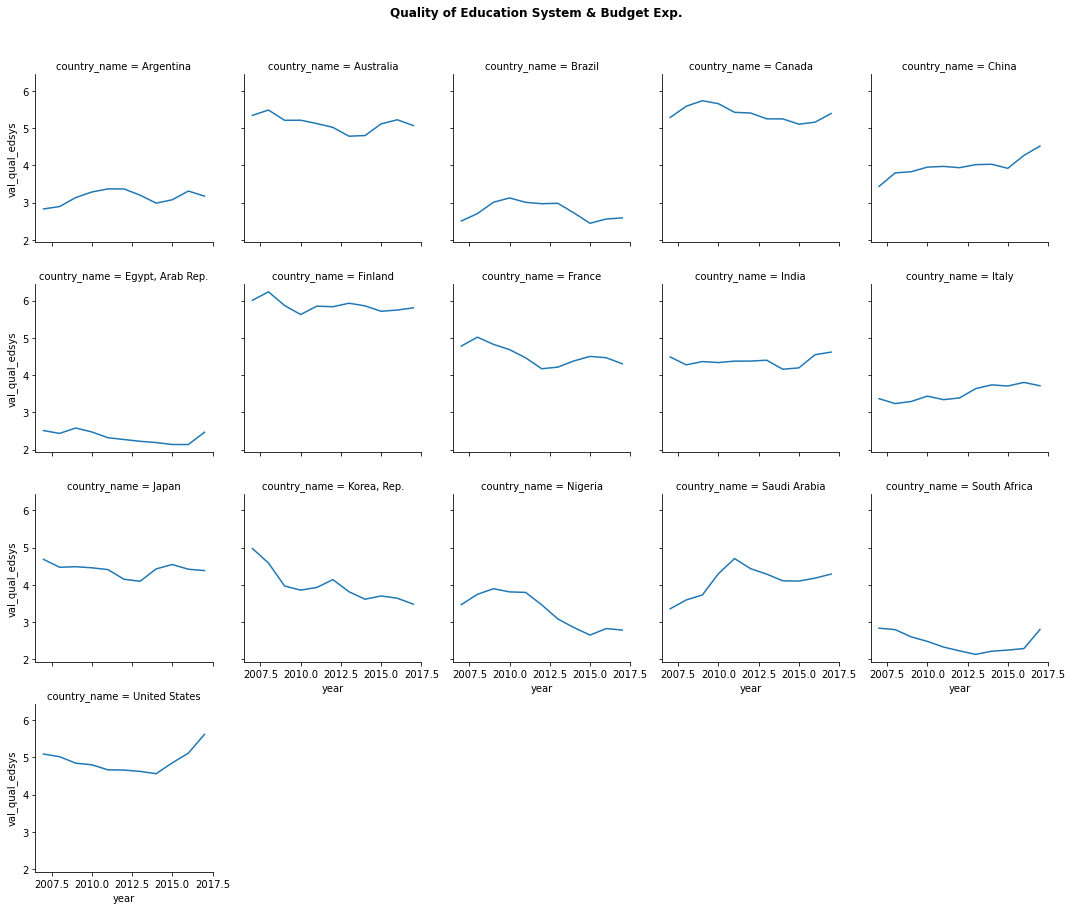

In [133]:
import seaborn as sns
g = sns.FacetGrid(edu_indicators_selected, col='country_name', palette='Set1', col_wrap=5)
g.map_dataframe(sns.lineplot,'year', 'val_qual_edsys')
g.fig.suptitle('Quality of Education System & Budget Exp.', y=1.05, fontweight='bold')

/var/folders/g2/rxrv5lvj0gzbd4fs1kyn5zgm0000gn/T/ipykernel_9341/4025864348.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_corr, dtype=np.bool))


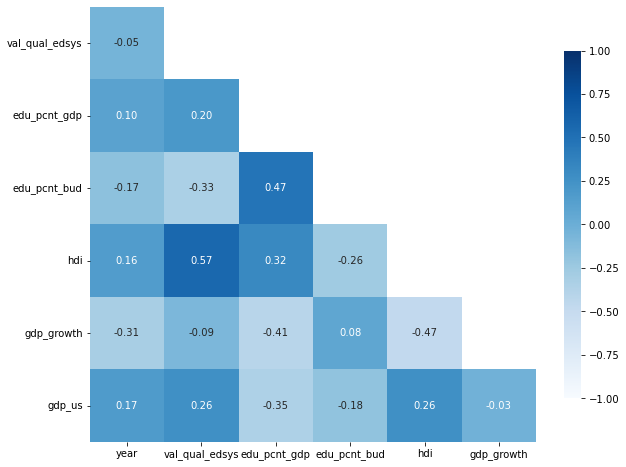

In [134]:
df_corr = edu_indicators_selected.corr()

fig, ax = plt.subplots(figsize=(10, 8))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()

Closing Connection

In [ ]:
conn.close()